In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.io.votable import parse_single_table
import time

In [2]:
#GOODS SOUTH STAR CHART within 100 arcmin, ordered by magnitude; downloaded using ASQL from GAIA DR3
table = parse_single_table("CANDLES2")
CANDLES=table.array

ra=[] #Right Ascension
dec=[] #Declination
mag=[] #Magnitude
ra_error = []
dec_error = []

for i in CANDLES[:]:    #Converts all mag, ra, and dec into floats from strings
    if i[2] != '':  #Some observations do not have a magnitude; so these are ignored
        if float(i[69]) < 16: #Faint stars of mag 16 and above are ignored (too faint for AO NGS)
            mag.append(float(i[69])) 
            ra.append(float(i[5])) 
            dec.append(float(i[7]))
            
scales=[] #Need scale values for the markersize of each star on a scatter plot to illustrate magnitude

for i in mag: #Linear with magnitude from 16, i.e mag 12 star has marker size 2 times larger than a mag 14 star.
    I = (16-i)
    scales.append(I*15)
    


In [3]:
def gnomonic(ra,dec,ra0,dec0): #Converts ra and dec (in rad) to x and y on a gnomonic projection plane around ra0 and dec0
    c = np.sin(dec0)*np.sin(dec)+np.cos(dec0)*np.cos(dec)*np.cos(ra-ra0)
    
    x=np.cos(dec)*np.sin(ra-ra0)
    y=np.cos(dec0)*np.sin(dec)-np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)
    
    return x/c,y/c

In [4]:
start=time.process_time()

ra0=53.14884949#Projection axis ra value / centre of FOV
dec0=-27.71123886 #Projection axis dec value / centre of FOV

techFOV = 10 #Technical field FOV in arcmin
scienceFOV = 7.5 #Science field FOV in arcmin

ra0_rad=np.radians(ra0) #Turns ra0 into radians
dec0_rad=np.radians(dec0) #Turns dec0 into radians

x=[] #x-coords of stars on gnomonic projection plane
y=[] #y-coords of stars on gnomonic projection plane
for i in range(0,len(ra)): #Takes every ra and dec value for the file and turns them into x and y under projection
    xval,yval=gnomonic(np.radians(ra[i]),np.radians(dec[i]),ra0_rad,dec0_rad) #Angles need to be in radians
    
    x.append(xval)
    y.append(yval)
    


void,techFOV_radius=gnomonic(ra0_rad,dec0_rad+np.radians(techFOV/2/60),ra0_rad,dec0_rad) #Calculates radius of the 10' FOV on the plane
void,scienceFOV_radius=gnomonic(ra0_rad,dec0_rad+np.radians(scienceFOV/2/60),ra0_rad,dec0_rad)

# #Plot of stars and FOVs
# fig, ax = plt.subplots(figsize=(20,20))
# plt.scatter(x,y,s=scales,edgecolors='black')

# FOV_techfield = plt.Circle((0,0), techFOV_radius, color='gray', alpha=0.3) #Technical field FOV
# FOV_sciencefield = plt.Circle((0,0), scienceFOV_radius, color='orange', alpha=0.3) #Science field FOV
# ax.add_patch(FOV_techfield)
# ax.add_patch(FOV_sciencefield)


In [5]:
# STARS WITHIN FOV

def distance(x,y): #Distance between FOV centre (0,0) and (x,y):
    d = np.sqrt(x**2+y**2)
    return d

sciencestars_index= [] #Index of stars inside science field
techstars_index = [] #Index of stars inside technical field and not in science field

for i in range(0,len(x)): #Retrieves indexes of stars within the radii.
    if distance(x[i],y[i]) < techFOV_radius:
        if distance(x[i],y[i]) < scienceFOV_radius:
            sciencestars_index.append(i)
        else:
            techstars_index.append(i)
    

print("Stars in FOV = "+str(len(techstars_index)+len(sciencestars_index)))
print("Stars in annulus = "+str(len(techstars_index)))
print("Stars in science field = "+str(len(sciencestars_index)))

period = time.process_time() - start
print("Time taken = {:.2}".format(period))

Stars in FOV = 4
Stars in annulus = 3
Stars in science field = 1
Time taken = 0.044


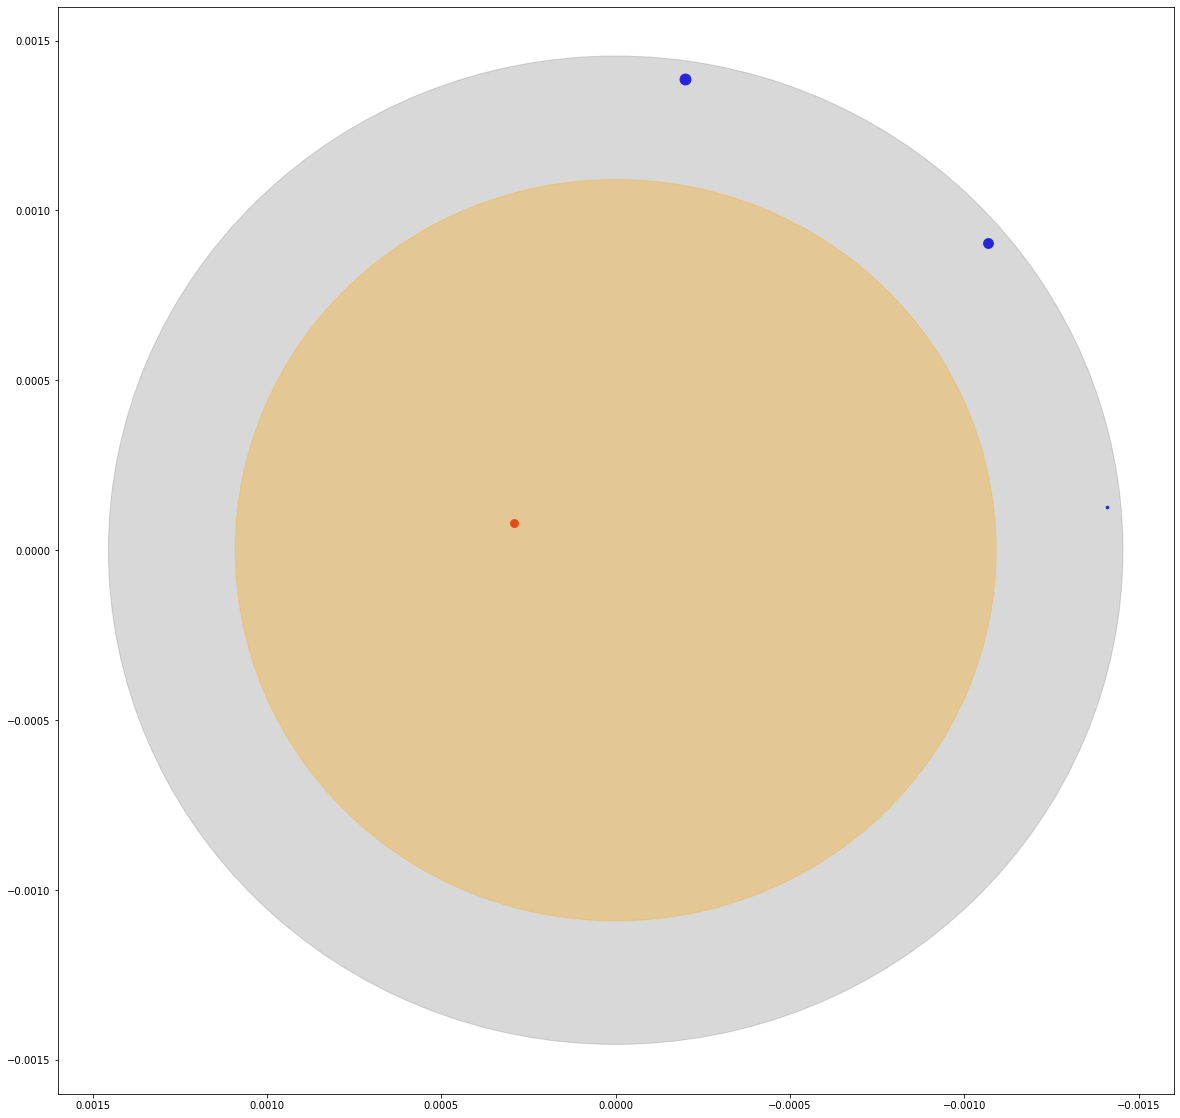

In [6]:
fig, ax = plt.subplots(figsize=(20,20))

for i in techstars_index:
    plt.scatter(x[i],y[i],s=scales[i]*2,color='blue')
for i in sciencestars_index:    
    plt.scatter(x[i],y[i],s=scales[i]*2,color='red')
    
FOV_techfield = plt.Circle((0,0), techFOV_radius, color='gray', alpha=0.3) #Technical field FOV
FOV_sciencefield = plt.Circle((0,0), scienceFOV_radius, color='orange', alpha=0.3) #Science field FOV
ax.add_patch(FOV_techfield)
ax.add_patch(FOV_sciencefield)

plt.gca().invert_xaxis()

In [7]:
#=====================================================================================================================
class FOV_stars:
    def __init__(self,scienceFOV_radius=7.4,techFOV_radius=10,mag_limit=16):
        self.scienceFOV_radius=scienceFOV_radius
        self.techFOV_radius=techFOV_radius
        self.mag_limit=mag_limit
        
    def loadstars(self): #Loads the stars near GOODS South
        #Loads GOODS SOUTH STAR CHART within 100 arcmin; downloaded using ASQL from GAIA DR3
        table = parse_single_table("CANDLES2")
        CANDLES=table.array

        self.ra=[] #Right Ascension
        self.dec=[] #Declination
        self.mag=[] #Magnitude
        for i in CANDLES[:]:    #Converts all mag, ra, and dec into floats from strings
            if i[2] != '':  #Some observations do not have a magnitude; so these are ignored
                if float(i[69]) < self.mag_limit: #Faint stars of mag {INSERT} and above are ignored (too faint for AO NGS)
                    self.mag.append(float(i[69])) 
                    self.ra.append(float(i[5])) 
                    self.dec.append(float(i[7]))
                    
        self.scales=[] #Need scale values for the markersize of each star on a scatter plot to illustrate magnitude

        for i in self.mag: #Linear with magnitude from 16, i.e mag 12 star has marker size 2 times larger than a mag 14 star.
            I = (16-i)
            self.scales.append(I*15)
            
    def gnomonic(ra,dec,ra0,dec0): #Converts ra and dec (in rad) to x and y on a gnomonic projection plane around ra0 and dec0
        c = np.sin(dec0)*np.sin(dec)+np.cos(dec0)*np.cos(dec)*np.cos(ra-ra0)

        x=np.cos(dec)*np.sin(ra-ra0)
        y=np.cos(dec0)*np.sin(dec)-np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)

        return x/c,y/c
    
    def distance(x,y): #Distance between FOV centre (0,0) and (x,y):
        d = np.sqrt(x**2+y**2)
        return d  

    
    def findstars(self,ra0,dec0,report=False): #Finds stars within the science and tech FOVS
        #ra0 and dec0 are pointing of the telescope/centre of FOV
        #Report set to true to returns processing time
        
        start = time.time() #Initial time of findstars
        



        ra0_rad=np.radians(ra0) #Turns ra0 into radians
        dec0_rad=np.radians(dec0) #Turns dec0 into radians

        x=[] #x-coords of stars on gnomonic projection plane
        y=[] #y-coords of stars on gnomonic projection plane
        for i in range(0,len(ra)): #Takes every ra and dec value for the file and turns them into x and y under projection
            xval,yval=gnomonic(np.radians(self.ra[i]),np.radians(self.dec[i]),ra0_rad,dec0_rad) #Angles need to be in radians

            x.append(xval)
            y.append(yval)



        void,techFOV_radius=gnomonic(ra0_rad,dec0_rad+np.radians(self.techFOV_radius/2/60),ra0_rad,dec0_rad) #Calculates radius of the 10' FOV on the plane
        void,scienceFOV_radius=gnomonic(ra0_rad,dec0_rad+np.radians(self.scienceFOV_radius/2/60),ra0_rad,dec0_rad)
    
        sciencestars_index= [] #Index of stars inside science field
        techstars_index = [] #Index of stars inside technical field and not in science field

        for i in range(0,len(x)): #Retrieves indexes of stars within the radii.
            if distance(x[i],y[i]) < techFOV_radius:
                if distance(x[i],y[i]) < scienceFOV_radius:
                    sciencestars_index.append(i)
                else:
                    techstars_index.append(i)


        print("Stars in FOV = "+str(len(techstars_index)+len(sciencestars_index)))
        print("Stars in annulus = "+str(len(techstars_index)))
        print("Stars in science field = "+str(len(sciencestars_index)))
        
        if report==True:
            
            period = time.time() - start
            print("Time taken = {:.2}".format(period))
            for i in techstars_index:
                print(mag[i])

            print("=======================")
            for i in sciencestars_index:
                print(mag[i])
        

        fig, ax = plt.subplots(figsize=(20,20))

        for i in techstars_index:
            plt.scatter(y[i],x[i],s=self.scales[i]*2,color='blue')
        for i in sciencestars_index:    
            plt.scatter(y[i],x[i],s=self.scales[i]*2,color='red')

        FOV_techfield = plt.Circle((0,0), techFOV_radius, color='gray', alpha=0.3) #Technical field FOV
        FOV_sciencefield = plt.Circle((0,0), scienceFOV_radius, color='orange', alpha=0.3) #Science field FOV
        ax.add_patch(FOV_techfield)
        ax.add_patch(FOV_sciencefield)
        
        plt.xlim(-techFOV_radius,techFOV_radius)
        plt.ylim(-techFOV_radius,techFOV_radius)
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()


In [8]:
a=FOV_stars()
a.loadstars()


Stars in FOV = 4
Stars in annulus = 3
Stars in science field = 1
Time taken = 0.077
12.024441719055176
12.791973114013672
15.77380084991455
13.93297290802002


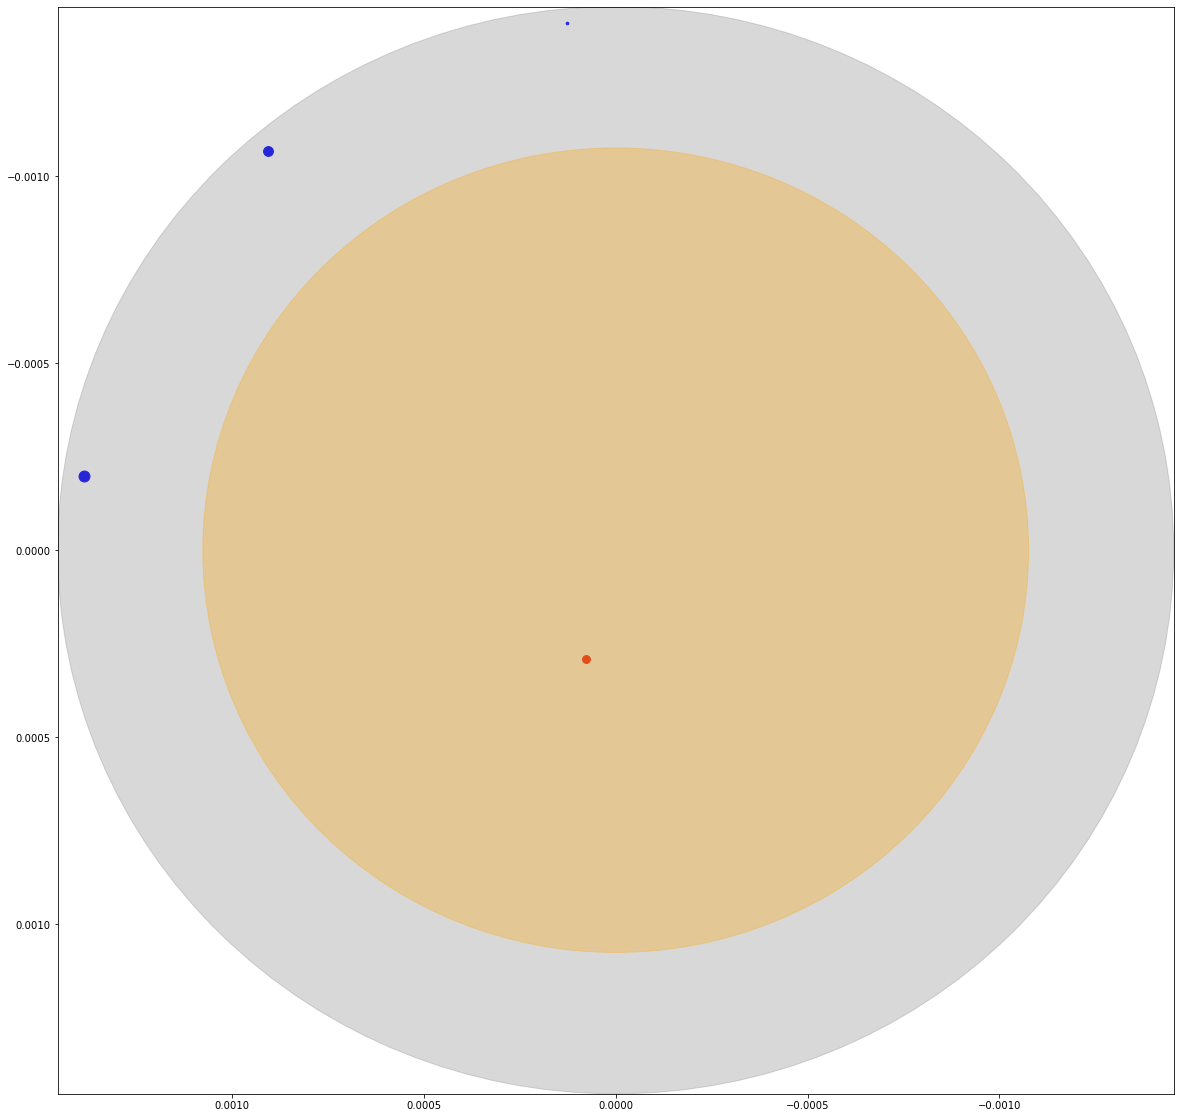

In [11]:
a.findstars(53.14884949,-27.71123886, report=True)

Stars in FOV = 4
Stars in annulus = 2
Stars in science field = 2
Time taken = 0.04
13.93297290802002
15.921266555786133
13.877452850341797
15.221957206726074


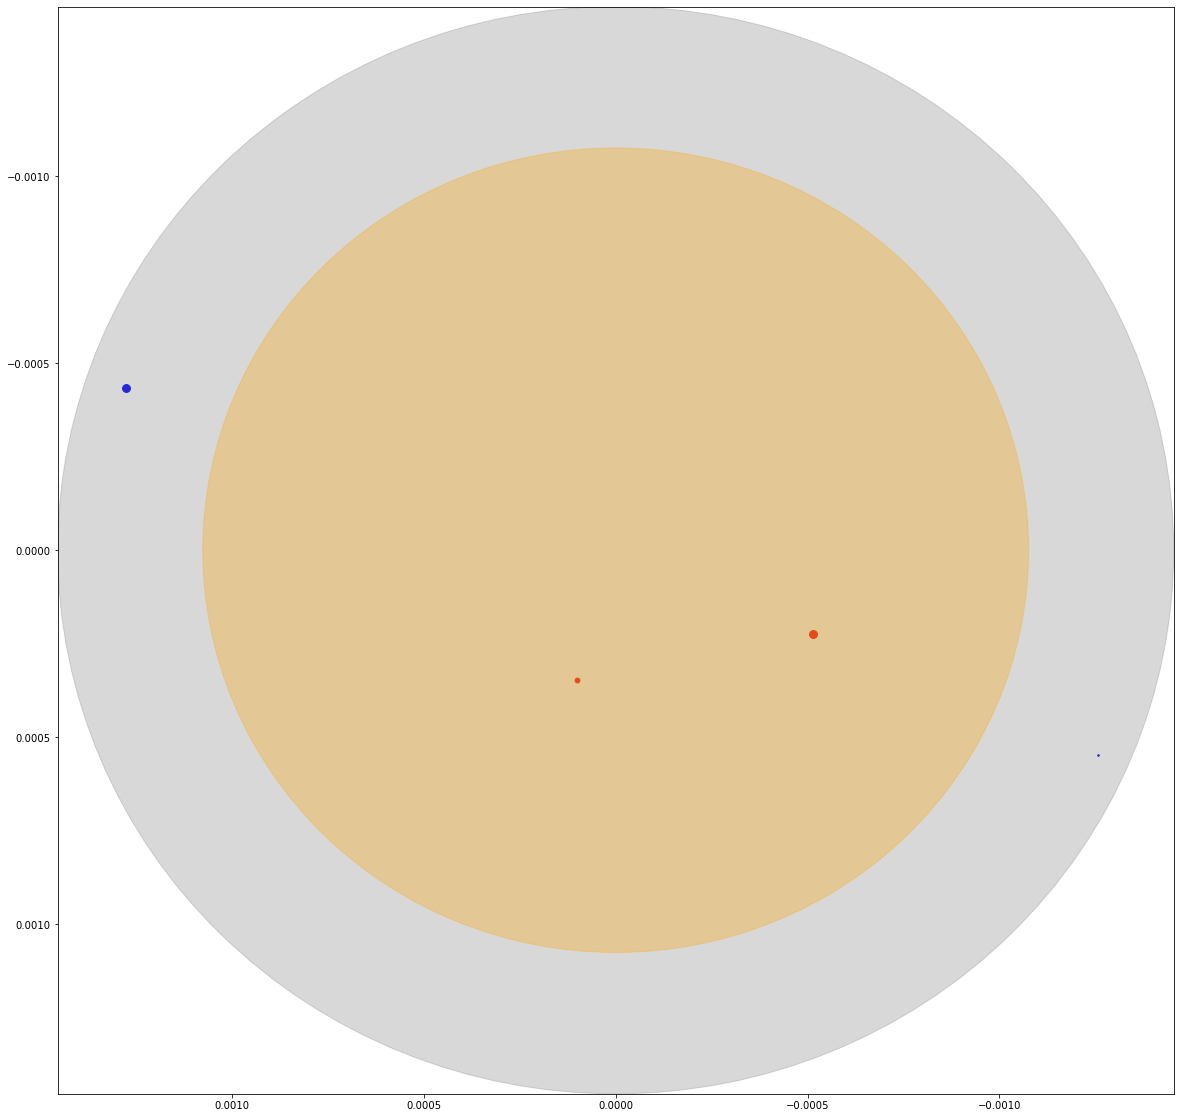

In [10]:
a.findstars(53.19574356, -27.77984810, report=True)